# Combination of Machine Learning Techniques and Oversampling Ratios for Credit Card Fraud Detection: A Comparative Analysis 

## Data Source
* kaggle.com: https://www.kaggle.com/datasets/kartik2112/fraud-detection

### Acnkowledgements
This dataset was designed by Kartik Shenoy using tools developed by Brandon Harris

# Importing necessary libraries and modules

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib

# Following code is to reset matplotlib settings as grids in plots seem to disappear sometimes rerunning this code fixes it
matplotlib.rcParams.update(mpl.rcParamsDefault)

# Initialising and Visualising Dataset

In [6]:
dataset = "fraudTest.csv"

In [7]:
df = pd.read_csv(dataset)

print("First few rows of the dataset:")
print(df.head())

# View the last few rows of the dataset (default is 5 rows)
print("\nLast few rows of the dataset:")
print(df.tail())

# View the summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(df.describe())

# View the column names of the dataset
print("\nColumn names of the dataset:")
print(df.columns)

# View the number of rows and columns in the dataset
print("\nNumber of rows and columns in the dataset:")
print(df.shape)

First few rows of the dataset:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             

# Preprocessing of the Dataset

#### Checking for missing values

In [8]:
# Checking for missing values in the dataset
print(df.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


 Dataset doesnt seem to have any missing values. This is probably due to the nature of the simulator created by Brandon Harris and used used by Kartik Shenoy to create this dataset

### Converting necessary columns to pd data frame, encoding categorical columns, scaling numerical columns and dropping unnecessary columns

In [9]:
# Converting string "trans_date_trans_time" to pd_datetime formate
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y/%m/%d %H:%M')

# Converting "trans_date_trans_time" to day, hour, minute and second format by initialising each in appropriate dt object
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek 
df['hour'] = df['trans_date_trans_time'].dt.hour
df['minute'] = df['trans_date_trans_time'].dt.minute
df['second'] = df['trans_date_trans_time'].dt.second

# Dropping the original 'trans_date_trans_time' column as we have already converted it to 
# a date-time object from pandas lib instead of its default being a string
df.drop('trans_date_trans_time', axis=1, inplace=True)

# Using LabelEncoder to convert categorical variables to numerical labels
# to avoid possible issues with algorithms only supporting numerical data,
# for example Logistic regression, Naive Bayes, K-NN
label_encoder = LabelEncoder()
df['merchant'] = label_encoder.fit_transform(df['merchant'])
df['category'] = label_encoder.fit_transform(df['category'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['job'] = label_encoder.fit_transform(df['job'])

# Scaling Numerical Features
# Standardize Standerdizing them to a range of mean 0 to variance 1
scaler = StandardScaler() # the function calculates standardize valuse z = x-mean/standard deviation
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
                      'day_of_week', 'hour', 'minute', 'second']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Sort the DataFrame by the day, hour, minute and seconf to maintain time order
df_sorted = df.sort_values(by=['day_of_week', 'hour', 'minute', 'second'])

# Cleaning dataset of non numerical columns and columns that shouldnt effect the model
# Also dropping cc_num because it is a catagorical column and shouldn't serve any purpose 
# in training the model. Dropping column 'Unnamed: 0' as it is 
# basically an unnecessary extra indexing caulumn created in the dataset and it throws, probably
# during its generation exceptions running following code
columns_to_drop = ['Unnamed: 0','cc_num', 'trans_num', 'street', 'city', 'state', 'zip', 'job', 'dob', 'first', 'last']
df_sorted = df_sorted.drop(columns_to_drop, axis=1)

# Displaying the first few rows of the cleaned DataFrame
print(df_sorted.head())

# Resetting the index of the sorted data frame to maintain a sequential order
df_sorted = df_sorted.reset_index(drop=True)

        merchant  category       amt  gender       lat      long  city_pop  \
180985       438        12 -0.393202       0 -0.535838 -0.283300 -0.284416   
218265       674         9 -0.417637       0  0.494721  0.759554 -0.293228   
121662       543         4  0.391380       0  0.597737  0.500528 -0.292795   
282481        77         2  0.046044       0  0.204896  0.201849 -0.293008   
505294       560         8 -0.434990       0  1.418055 -0.606487 -0.293481   

        unix_time  merch_lat  merch_long  is_fraud  day_of_week      hour  \
180985  -0.649183  -0.388932   -0.310080         0    -1.251574 -1.880666   
218265  -0.416616   0.311756    0.718358         0    -1.251574 -1.880666   
121662  -0.998031   0.683311    0.489241         0    -1.251574 -1.880666   
282481   0.048517   0.062223    0.253564         0    -1.251574 -1.880666   
505294   1.327631   1.589652   -0.560482         0    -1.251574 -1.880666   

          minute    second  
180985 -1.701339 -1.588822  
218265 -1.

##### This was done with the use of and help of code from:
* pd_datetime: https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html
* label_encoder: https://vitalflux.com/labelencoder-example-single-multiple-columns/
* StandardScaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# Outlier detection of Dataset Using Isolation Forest model

This algorithm can detect outliers by using the principles of trees. It can do so by identifying data points that are isolated when building trees.

Number of outliers detected using Isolation Forest: 54200


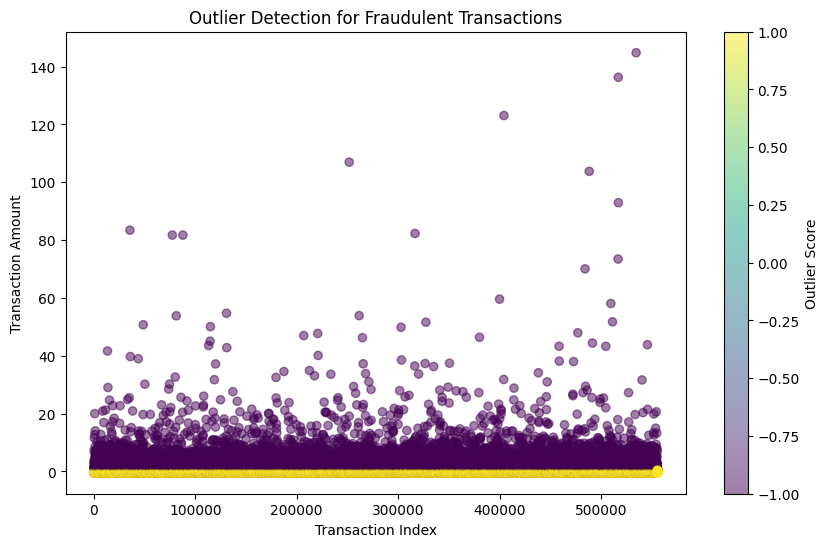

In [10]:
# Using Isolation forest to visualise ouliers in the dataset
# Using unsorted original dataset as we want to see the outliers in the original dataset
# Extracting the 'amt' column and return it as a dataframe for outlier detection
X_outliers = df[['amt']]

# Create an instance of the Isolation Forest model for outlier detection.
# The 'contamination' parameter is set to 'auto', which will automatically determine 
# the fraction of outliers in the dataset. The 'random_state' is set for reproducibility.
iso_outlier_model = IsolationForest(contamination='auto', random_state=42)

# Fitting Isolation Forest model on the data column. This trains the model to understand the 
# data distribution and identify potential outliers.
iso_outlier_model.fit(X_outliers)

# Fitting the model to the data and predict outliers
outlier_preds = iso_outlier_model.fit_predict(X_outliers)
# Counts and displays the outliers
outlier_count = (outlier_preds == -1).sum() # checks predictions in outlier_pred for value -1 (frauds) and 1 (legit) because in Iso Forest predictions are made in classes on 1 and -1, -1 represented in the outliers
# Displaying the number of detected outliers to the console.
print(f"Number of outliers detected using Isolation Forest: {outlier_count}")

# Displays the actual outlier rows (Uncomment the 2 lines below to view rows with outliers)
# outlier_rows = df[outlier_preds == -1]
# print(outlier_rows)

# contains the predicted outlier labels from the Isolation Forest model.
df['outlier'] = outlier_preds

# Plotting the data, each point represents a transaction with its index on the x-axis
# and its amount on the y-axis. Points are colored based on whether they're predicted 
# as outliers or not, using the 'outlier' column.
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['amt'], c=df['outlier'], cmap='viridis', alpha=0.5)

# Adds a colorbar to the plot to show the meaning of colors (outlier or inlier).
plt.colorbar(label='Outlier Score')

# Setting the title and axis labels for the plot.
plt.title('Outlier Detection for Fraudulent Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
# Display the plot.
plt.show()

Using the column __"amt"__ for outlier detection, as fraudulant transactions may often be of anomalous amounts whether larger or smaller, possibly to check for unauthorised gains. Further detecting outliers on a single column makes the model simpler

* Code for Isolation forest has been adapted following documentation from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
* Scatter plot code from: https://www.geeksforgeeks.org/matplotlib-pyplot-scatter-in-python/

# Visualising Isolation Forest model's performance in a bar chart

Accuracy: 0.9044
Precision: 0.0299
Recall: 0.7543
F1 Score: 0.0574


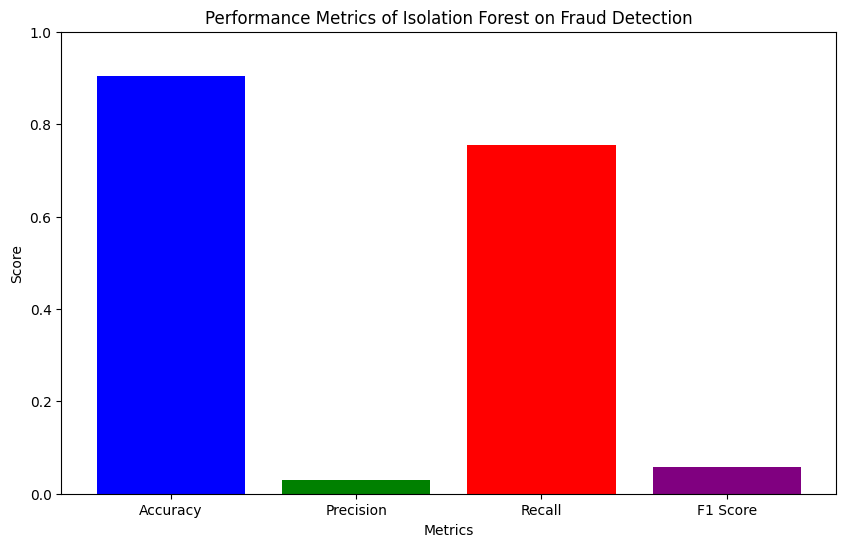

In [12]:
# Converting is_fraud 0(legit) and 1(fraud) to return 1(legit) and -1(fraud) instead to match isolation Forests prediction pattern
def convert_label(x):
    return 1 if x == 0 else -1

y_true = df['is_fraud'].apply(convert_label)


# Validating the model's prediction against actual fraudulant class 
accuracy = accuracy_score(y_true, outlier_preds)
precision = precision_score(y_true, outlier_preds, pos_label=-1)
recall = recall_score(y_true, outlier_preds, pos_label=-1)
f1 = f1_score(y_true, outlier_preds, pos_label=-1)

# Printing metrics to 4 decimal points
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting for visualisation
# Listing the anmes of the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Their corresponding values
values = [accuracy, precision, recall, f1]

# Creating bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)  # set y-axis limits to range between 0 and 1
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics of Isolation Forest on Fraud Detection')
plt.show()

* Bar chart plot code from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

# Isolation Forest performance
* Accuracy represents This is the ratio of correct predictions, both normal and fraudulent to the total number of transactions.An accuracy of 90.44% suggests that the majority of predictions are correct, however trusting accuracy alone is often misleading.
* Precision indicates the correctness of the detected fraudulent transactions. Meaning for this model, that only about 2.99% of the transactions labeled as fraudulent were actual frauds.
* Recall shows the True Positive Rate also known as Sensitivity. It measures how many of the actual fraudulent transactions were correctly identified by the model. In this case the model detected 75.43% of all actual frauds.
* The F1 Score is the harmonic mean of precision and recall. An F1 Score of 5.74% indicates that the balance between precision and recall is leaning more towards recall. This is seen by the low precision and high recall values.

# Data Imbalance

0    553574
1      2145
Name: is_fraud, dtype: int64
   index  is_fraud
0      0    553574
1      1      2145
Percentage of fraudulent transactions: 0.39%
Total Fraudulant Transactions: 2145.00
Total Transactions: 553574.00


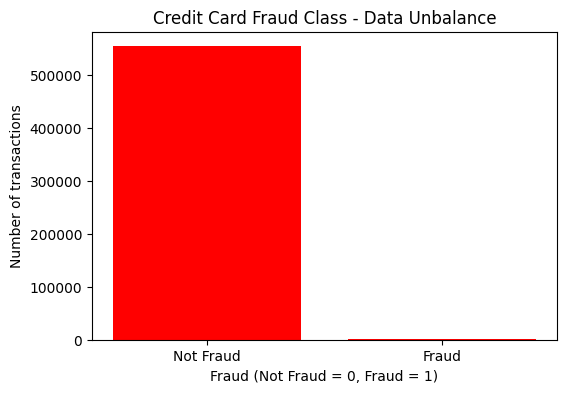

In [13]:
# Visualising data imbalance
# Get the count of each class (fraudulent and non-fraudulent transactions)
temp = df['is_fraud'].value_counts() # Counts each unique values 0 and 1 as the index and their counts as their values
print(temp) # Shows that the unique values are currently the dataframes index

# Create a DataFrame for plotting
imb_df = pd.DataFrame(temp).reset_index() # creates a new index so the unique values are now a column
print(imb_df)
imb_df.columns = ['Fraud', 'Number of transactions'] # this replaces columns "index" and "is_fraud"


# Print the number of fraudulent transactions
total_transactions = temp.sum()
percentage_frauds = (temp[1] / total_transactions) * 100

# Print the percentage of fraudulent transactions
print("Percentage of fraudulent transactions: {:.2f}%".format(percentage_frauds))
print("Total Fraudulant Transactions: {:.2f}".format(temp[1]))
print("Total Transactions: {:.2f}".format(temp[0]))

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(imb_df['Fraud'], imb_df['Number of transactions'], color='red')
plt.xlabel('Fraud (Not Fraud = 0, Fraud = 1)')
plt.ylabel('Number of transactions')
plt.title('Credit Card Fraud Class - Data Unbalance')
plt.xticks(imb_df['Fraud'], ['Not Fraud', 'Fraud'])
plt.show()

As expected from a fraud detection dataset. We can see that the number of actual fraudulant transactions are with in a tiny fraction of the total transactions. This proves shows how large the imbalance in the data is and would require to be oversampled before feeding it to an algorithm

# Data Oversampling and Fitting

In [14]:
# Dropping "is_fraud" so the machine learning models can't know which transaction is farud by default
# to make it the input feature for the algorithms
# Removeing "is_fraud" from input features, to not let the machine learning algorithm to essentially cheat
X = df_sorted.drop('is_fraud', axis=1)
# Setting "is_fraud" to y to make it the target variable for this model
y = df_sorted['is_fraud']

# Apply SMOTE to oversample the minority class as we saw previously the imbalance in legitimate and
# fraudulant transactions is very large making the data very imbalance.
smote = SMOTE(sampling_strategy= 0.3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

SMOTE and Train_Test_Split used following their standard method from:
* SMOTE: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
* Train_Test_Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## NOTICE: All scores for wach model for training and test data on each SMOTE Ratios and cross validation scores on test data will be provided with supposrting document in an Excel sheet
Follow this link to access the backup on GitHub: https://github.com/Booolzay/MSc-Project---Comparative-analysis-of-ML-Models-for-a-Credit-card-fraud-detection-system/tree/main

# Logistic Regression
Using logistic regression due to its simplicity and interpretability allow for easy understanding and diagnosis of model decisions. It provides a probabilistic framework for binary classification, making it a good for distinguishing between fraudulent and non-fraudulent credit card transactions.

In [16]:
# Logistic regression
# Creating an instanc of a Logistic Regression model
logreg_model = LogisticRegression()

# Training the model
logreg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = logreg_model.predict(X_test)

# Evaluating model by predicting on training data to check for overfitting
y_train_pred_logReg = logreg_model.predict(X_train)

print("Logistic Regression training Data Performance:")
print(classification_report(y_train, y_train_pred_logReg))

# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training Data Performance:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95    442798
           1       0.93      0.68      0.78    132918

    accuracy                           0.91    575716
   macro avg       0.92      0.83      0.87    575716
weighted avg       0.92      0.91      0.91    575716

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95    110776
           1       0.93      0.67      0.78     33154

    accuracy                           0.91    143930
   macro avg       0.92      0.83      0.86    143930
weighted avg       0.91      0.91      0.91    143930



Here the algorithm estimates the probability of a transaction being fraudulent based on the given input features(X). If the probability surpasses a predefined threshold, the model classifies the transaction as fraudulent, else legitimate. And based on the f1-score similar performance of both training and test sets suggests no over fitting. Over fitting generally returns exceptionally high results on training sets and performs poorly on test sets as suggested by thisarticle: https://aws.amazon.com/what-is/overfitting/#:~:text=Overfitting%20is%20an%20undesirable%20machine,on%20a%20known%20data%20set.
* Logistic regerssion model made with standard method from: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# New transaction for prediction

In [20]:
# Hypothetical new transaction (unseen data)
new_transaction = {
    'merchant': 800, # A marchent number betweel 1-800 as specified in the data's description
    'category': 12, # assuming a category
    'amt': 250.75,  # assuming an amount
    'gender': 0, 
    'lat': 34.0522,  # Latitude for Los Angeles, CA
    'long': -118.2437,  # Longitude for Los Angeles, CA
    'city_pop': 3792621,  # Population of Los Angeles, CA
    'unix_time': 1677668800,  # Just an example timestamp
    'merch_lat': 34.0527,  # slightly different latitude for the merchant's location
    'merch_long': -118.2458,  # slightly different longitude for the merchant's location
    'day_of_week': 3,  # Wednesday, if considering 0 = Sunday
    'hour': 14,  # 2 PM
    'minute': 35,  # 35th minute
    'second': 15  # 15th second
}

# Convert the new transaction data to a DataFrame
# ... (Your code up to defining new_transaction)

# Convert the new transaction data to a DataFrame
new_data = pd.DataFrame([new_transaction])

# Scale the numerical features using the same scaler used for training
new_data[numerical_features] = scaler.transform(new_data[numerical_features])

# Cross Validation for Logistic Regression and Prediction on 'new_data'

In [28]:
# Cross-validating the Logistic regression algorithm at oversampling rate
cross_val_scores_logReg = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_logReg)
print("Mean Cross Validation Score:", cross_val_scores_logReg.mean())

# Making predictions using the trained logistic regression model
predicted_class_logReg = logreg_model.predict(new_data)
print(predicted_class_logReg)
# Mapping the predicted class to label fraud or not fraud
predicted_label_logreg = 'Fraud' if predicted_class_logReg[0] == 1 else 'Not Fraud'
# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_logreg)

C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin


Cross Validation Scores: [0.91422045 0.9137681  0.91372467 0.91464527 0.91440209]
Mean Cross Validation Score: 0.9141521165499344
[0]
Predicted Label for the New Transaction: Not Fraud


C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross_val_score used following for all algorithms: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

# Visual Evaluations of Logistic Regression

[[109191   1585]
 [ 10886  22268]]


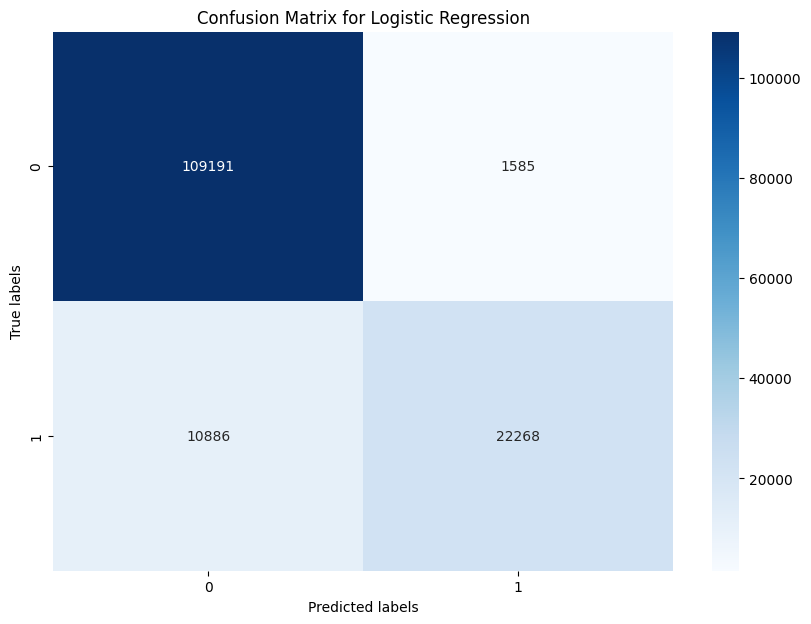

In [118]:
# Confusion matrix plot for Log reg
# Predicting using Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test)  # Using the provided Logistic Regression model

conf_matrix_logReg = confusion_matrix(y_test, y_pred_logreg)
print(conf_matrix_logReg)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_logReg, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


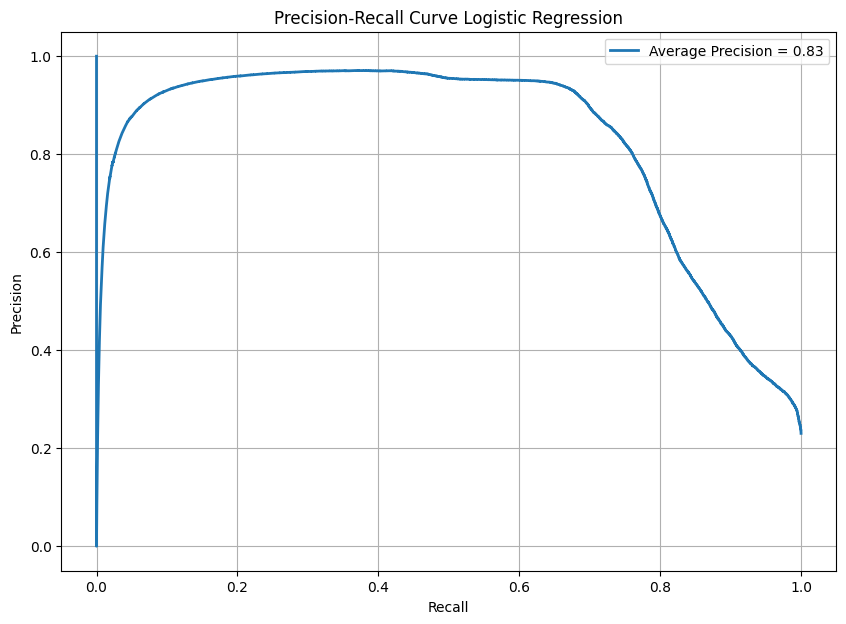

In [121]:
# Precission Recall Curve for Log Reg
logReg_y_prob = logreg_model.predict_proba(X_test)[:, 1]  # Getting the probabilities for the positive class using predict_proba method of the logReg model

# Precision-Recall curve
logReg_precision, logReg_recall, _ = precision_recall_curve(y_test, logReg_y_prob)
avg_precision_logReg = average_precision_score(y_test, logReg_y_prob)

plt.figure(figsize=(10, 7))
plt.plot(logReg_recall, logReg_precision, label='Average Precision = %0.2f' % avg_precision_logReg, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Logistic Regression')
plt.legend(loc="upper right")
plt.grid()
plt.show()

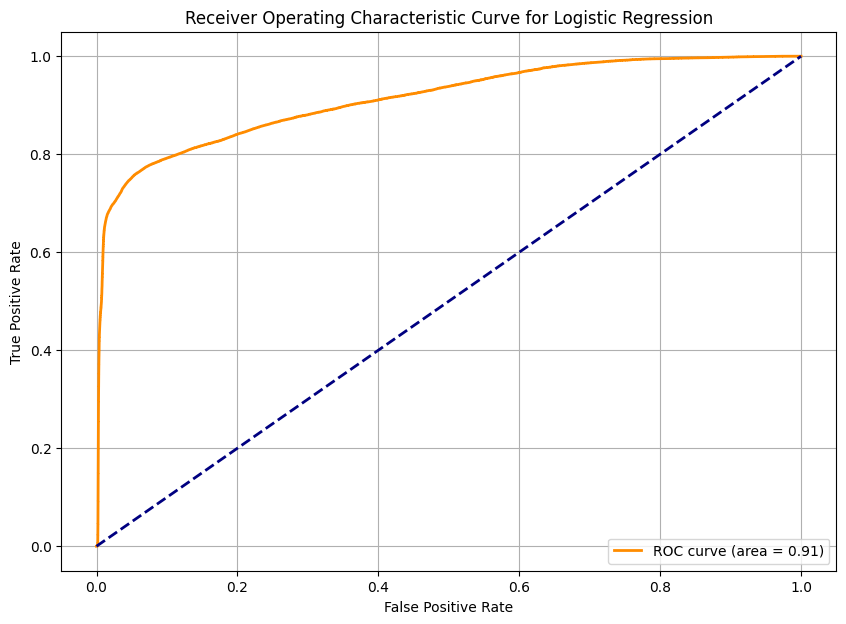

In [50]:
#ROS-AUC Cruve for Log Reg
logReg_fpr, logReg_tpr, _ = roc_curve(y_test, logReg_y_prob) # "_" is a disposable variable to store the threshold returned by this function which is not needed
logReg_roc_auc = auc(logReg_fpr, logReg_tpr)

plt.figure(figsize=(10, 7))
plt.plot(logReg_fpr, logReg_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % logReg_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Metric Plots for ROC-AUC, Confusion Matrix and Precision-Recall curves are from:
* ROC-AUC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
* Confusion matris: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
* Precision-Recall: https://www.datacamp.com/tutorial/precision-recall-curve-tutorial

##### Same methods are used throughout the notebook for all algorithms

# Random Forest

Random Forest operates by constructing multiple decision trees during training and outputting the mode of the classifications for classification tasks or mean prediction for regression task of each individual trees.

In [22]:
#RANDOM FOREST

# Defining the model
rf = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=100, random_state = 42) # Tuned these hyperparameters to make the algorithm run a little faster and reduce chance of overfitting otherwise returns almost perfect score
# Fitting the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate model on training data to check for overfitting
y_train_pred_rf = rf.predict(X_train)

print("Random forest Training Data Performance:")
print(classification_report(y_train, y_train_pred_rf))

# Print classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random forest Training Data Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    442798
           1       0.97      0.88      0.93    132918

    accuracy                           0.97    575716
   macro avg       0.97      0.94      0.95    575716
weighted avg       0.97      0.97      0.97    575716

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    110776
           1       0.97      0.88      0.92     33154

    accuracy                           0.97    143930
   macro avg       0.97      0.94      0.95    143930
weighted avg       0.97      0.97      0.97    143930



Implementing Random forest with default parameters return absolute perfect score in trainng but slightly low in test, suggesting some possible overfitting. However tuning these selected hyperparameters improve the resul as now training data don't return perfect score while test scores performing almost same.
Implementation and hyperparameters for this algorithm tuned following guidances from:
* sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* towardsdatascience.com: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74#:~:text=For%20hyperparameter%20tuning%2C%20we%20perform,evaluate%20on%20the%20testing%20set.

# Cross Validation for Random Forest

In [23]:
# Cross-validating the Random Forest algorithm at oversampling rate 1
cross_val_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_rf)
print("Mean Cross Validation Score:", cross_val_scores_rf.mean())

# Making predictions using the trained Random Forest model
predicted_class_rf = rf.predict(new_data)
print(predicted_class_rf)
# Mapping the predicted class to label fraud or not fraud
predicted_label_rf = 'Fraud' if predicted_class_rf[0] == 1 else 'Not Fraud'
# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_rf)


Cross Validation Scores: [0.9658254  0.9663983  0.96643304 0.96741443 0.96630277]
Mean Cross Validation Score: 0.9664747907812004
[0]
Predicted Label for the New Transaction: Not Fraud


# Visual Evaluations of Random Forest

[[109890    886]
 [  3954  29200]]


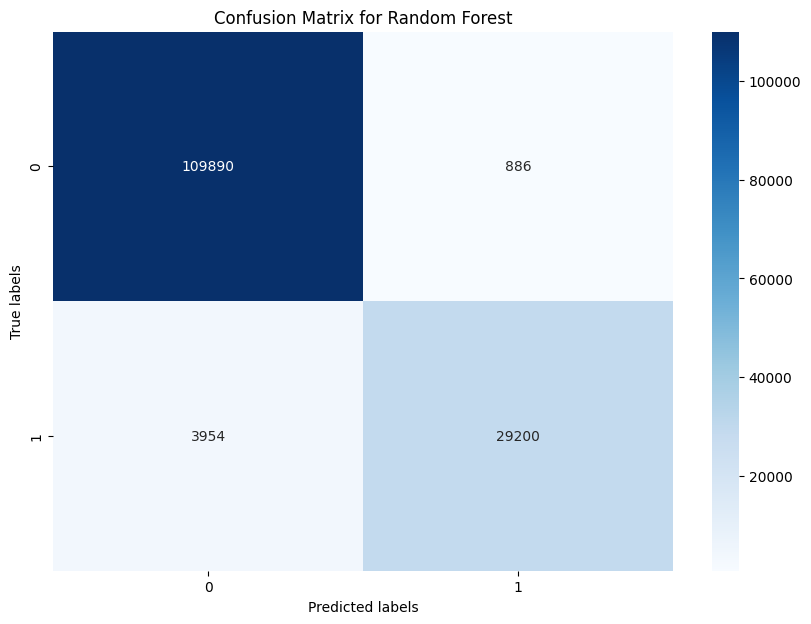

In [115]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


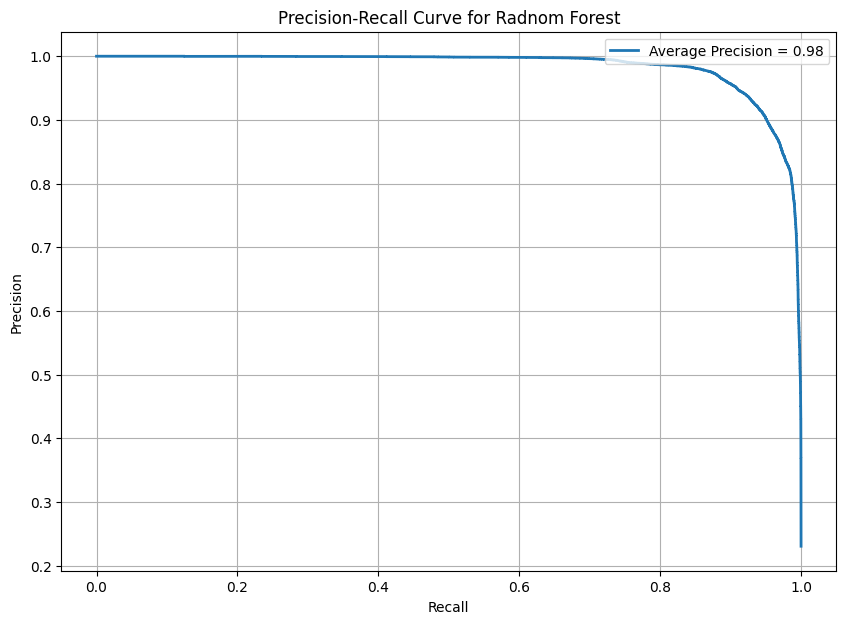

In [122]:
#Precision-Recall Curve for Random forest
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # Assuming your model can provide probabilities

rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_prob_rf)
avg_precision_rf = average_precision_score(y_test, y_prob_rf)

plt.figure(figsize=(10, 7))
plt.plot(rf_recall, rf_precision, label='Average Precision = %0.2f' % avg_precision_rf, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Radnom Forest')
plt.legend(loc="upper right")
plt.grid()
plt.show()


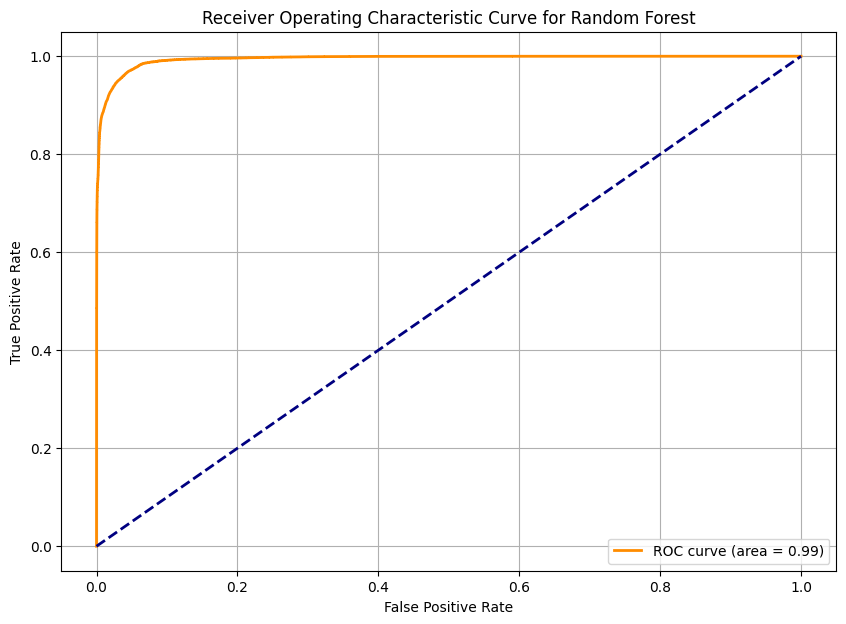

In [70]:
#ROC-AUC for
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob_rf)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 7))
plt.plot(rf_fpr, rf_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()



# Gradient Boosting

Gradient boosting works by sequentially building decision trees, where each tree corrects the errors of its predecessor. By combining the predictions of multiple weak learnening trees, the model becomes a stronger predictor.

In [30]:
# Initializing the GradientBoostingClassifier with some tweaks
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.8,
    random_state=42
)

# Train the model using the resampled training data
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate model on training data to check for overfitting
y_train_pred_gb = gb_model.predict(X_train)

print("Gradient Boosting Training Data Performance:")
print(classification_report(y_train, y_train_pred_gb))

# Print classification report for test data
print("\nGradient Boosting Test Data Performance:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Training Data Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    442798
           1       0.95      0.84      0.89    132918

    accuracy                           0.95    575716
   macro avg       0.95      0.91      0.93    575716
weighted avg       0.95      0.95      0.95    575716


Gradient Boosting Test Data Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    110776
           1       0.95      0.84      0.89     33154

    accuracy                           0.95    143930
   macro avg       0.95      0.91      0.93    143930
weighted avg       0.95      0.95      0.95    143930



Tuned hyperparameters for similar reasons to random forest, however the focus for this algorithm was mostly to have it run a little faster.

Implementation and hyperparameter tuning done with asimilar idea of the Random forest classifier however utilising Gradient boosting documentation instead:

* Gradient Boosting: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

# Cross Validation for gradiant boosting model

In [31]:
# Cross-validating the Gradient Boosting algorithm at oversampling rate 1
cross_val_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_gb)
print("Mean Cross Validation Score:", cross_val_scores_gb.mean())

# Making predictions using the trained Gradient boosting model
predicted_class_gb = gb_model.predict(new_data)
print(predicted_class_gb)
# Mapping the predicted class to label fraud or not fraud
predicted_label_gb = 'Fraud' if predicted_class_gb[0] == 1 else 'Not Fraud'
# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_gb)


Cross Validation Scores: [0.95245084 0.95122587 0.95249386 0.95256333 0.95298889]
Mean Cross Validation Score: 0.9523445585908927
[0]
Predicted Label for the New Transaction: Not Fraud


# Visual Evaluations of Gradient Boosting

Confusion Matrix:
 [[109324   1452]
 [  5470  27684]]


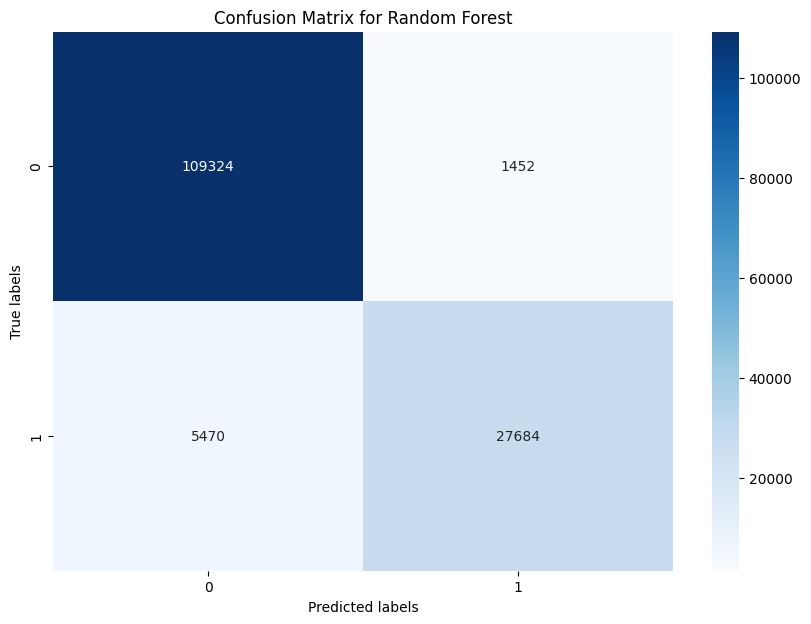

In [110]:
# Confusion matrix for gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix:\n", conf_matrix_gb)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_gb, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


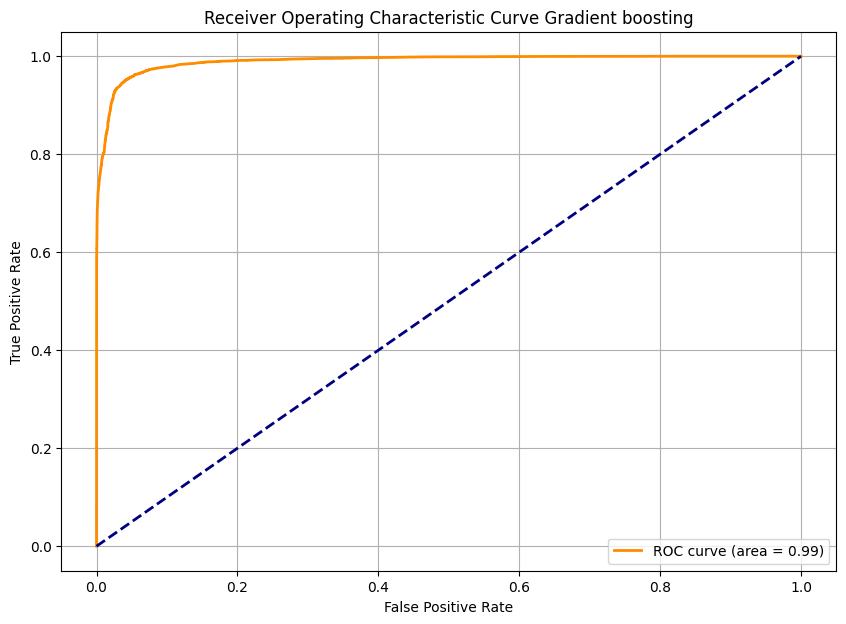

In [123]:
# Getting the prediction probabilities
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
gb_fpr, gb_tpr, _ = roc_curve(y_test, y_pred_prob_gb)
gb_roc_auc = auc(gb_fpr, gb_tpr)

plt.figure(figsize=(10, 7))
plt.plot(gb_fpr, gb_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve Gradient boosting')
plt.legend(loc='lower right')
plt.grid()
plt.show()


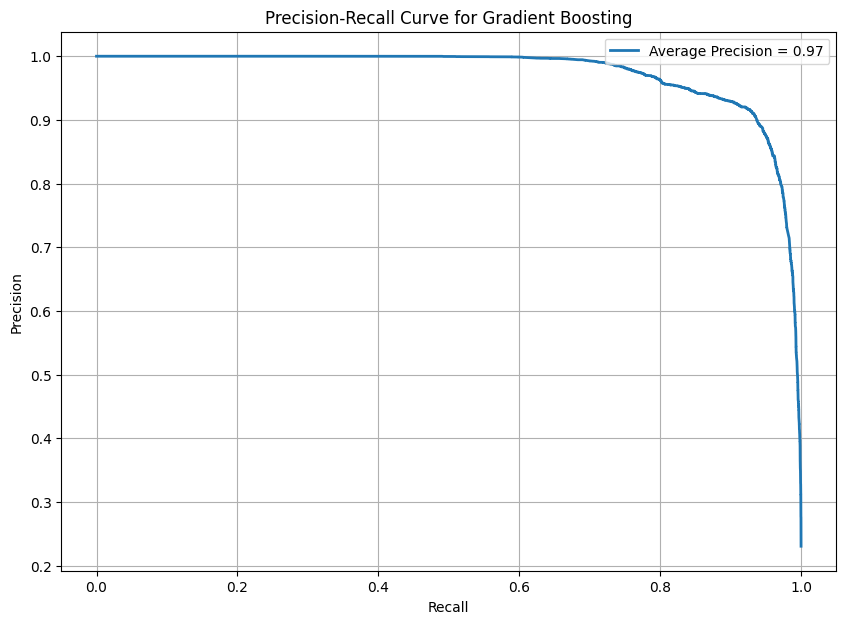

In [80]:
#ROC-AUC for Gradient Boosting
gb_precision, gb_recall, _ = precision_recall_curve(y_test, y_pred_prob_gb)
avg_precision_gb = average_precision_score(y_test, y_pred_prob_gb)

plt.figure(figsize=(10, 7))
plt.plot(gb_recall, gb_precision, label='Average Precision = %0.2f' % avg_precision_gb, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting')
plt.legend(loc="upper right")
plt.grid()
plt.show()




# Gaussian Naive Bayes

Gaussian Naive Bayes work by assuming that the features follow a normal distribution (Gaussian). It calculates the probabilities of each class given the feature values, and then predicts the class with the highest probability. It then applies Bayes' theorem and makes the naive assumption that features are independent given the class, GNB can efficiently handle large datasets and may uncover underlying patterns that help in distinguishing between the classes, in this case fraud and legit transactions

In [89]:
#Naive BAYSE
# Initializing the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Training the model using the training data
gnb.fit(X_train, y_train)

# Predicting on the test set
y_pred_gnb = gnb.predict(X_test)

# Evaluating model on training data to check for overfitting
y_train_pred_gnb = gnb.predict(X_train)

print("Gaussian Naive Bayes Training Data Performance:")
print(classification_report(y_train, y_train_pred_gnb))

# Print classification report for the test set
print("Gaussian Naive Bayes Classification Report (Test Data):")
print(classification_report(y_test, y_pred_gnb))

# Confusion matrix for the test set
conf_matrix_nb = confusion_matrix(y_test, y_pred_gnb)
print("Confusion Matrix (Test Data):\n", conf_matrix_nb)

# Predicting on new_data
predicted_class_nb = gnb.predict(new_data)
predicted_label_nb = 'Fraud' if predicted_class_nb[0] == 1 else 'Not Fraud'
print("Predicted Label for the New Transaction using Naive Bayes:", predicted_label_nb)


Gaussian Naive Bayes Training Data Performance:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94    442798
           1       0.92      0.64      0.76    132918

    accuracy                           0.90    575716
   macro avg       0.91      0.81      0.85    575716
weighted avg       0.91      0.90      0.90    575716

Gaussian Naive Bayes Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94    110776
           1       0.92      0.64      0.76     33154

    accuracy                           0.91    143930
   macro avg       0.91      0.81      0.85    143930
weighted avg       0.91      0.91      0.90    143930

Confusion Matrix (Test Data):
 [[108938   1838]
 [ 11820  21334]]
Predicted Label for the New Transaction using Naive Bayes: Not Fraud


Code implemented using default properties of Gaussian Naive Bayes from : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

# Cross Validation for Gaussian Naive Bayes

In [82]:
# Cross-validating the Gaussian Naive Bayes algorithm at oversampling rate 
cross_val_scores_gnb = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_gnb)
print("Mean Cross Validation Score:", cross_val_scores_gnb.mean())

# Making predictions using the trained logistic regression model
predicted_class_gnb = gnb.predict(new_data)
print(predicted_class_gnb)
# Mapping the predicted class to label fraud or not fraud
predicted_label_gnb = 'Fraud' if predicted_class_gnb[0] == 1 else 'Not Fraud'
# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_gnb)


Cross Validation Scores: [0.90607413 0.90360682 0.9039021  0.905283   0.90527431]
Mean Cross Validation Score: 0.9048280727892564
[0]
Predicted Label for the New Transaction: Not Fraud


# Visual Evaluations of Gaussian Naive Bayes

Confusion Matrix:
 [[108938   1838]
 [ 11820  21334]]


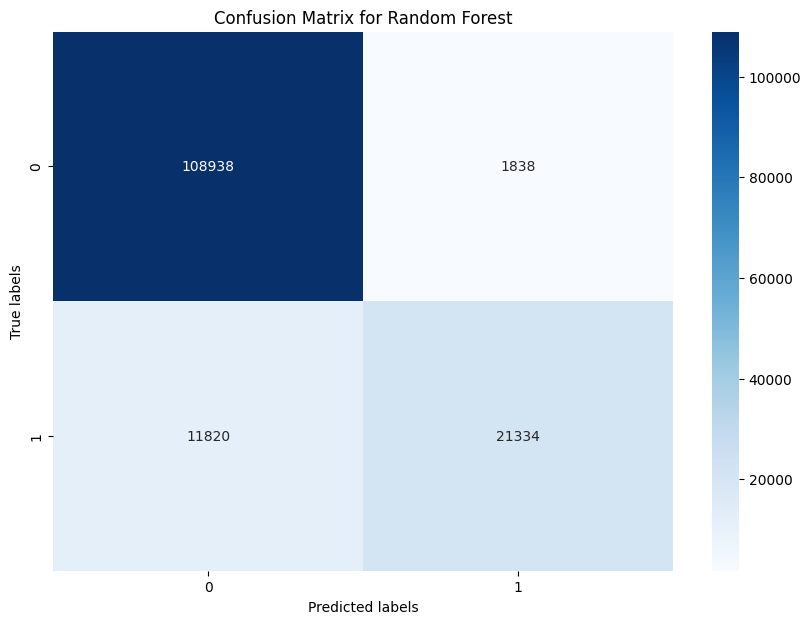

In [109]:
# Confusion Matrix for Gaussian Naive Bayes
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
print("Confusion Matrix:\n", conf_matrix_gnb)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

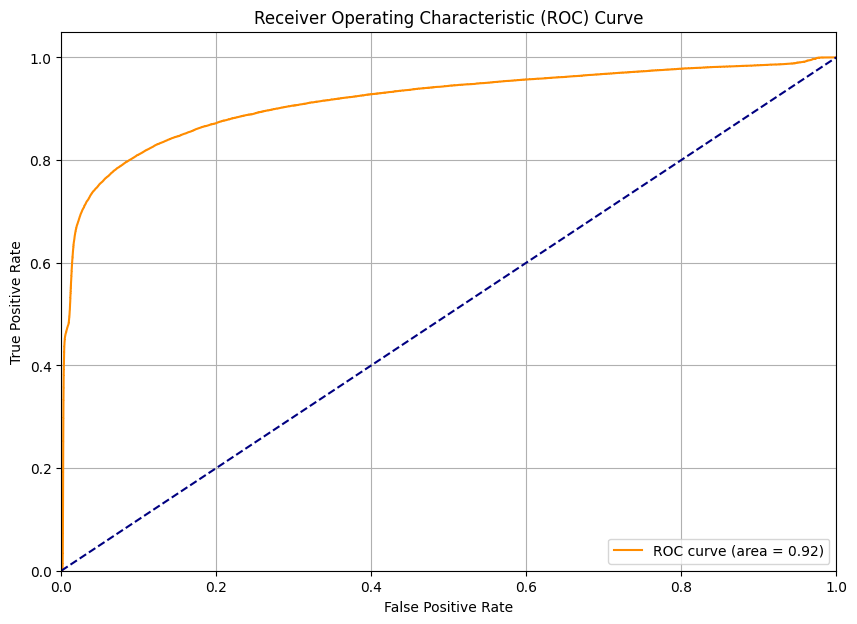

In [97]:
# Get the prediction probabilities
y_pred_prob_gnb = gnb.predict_proba(X_test)[:, 1]

# Compute the ROC curve
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, y_pred_prob_gnb)

# Compute the AUC
gnb_roc_auc = auc(gnb_fpr, gnb_tpr)
plt.figure(figsize=(10, 7))
plt.plot(gnb_fpr, gnb_tpr, color='darkorange', label='ROC curve (area = %0.2f)' % gnb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

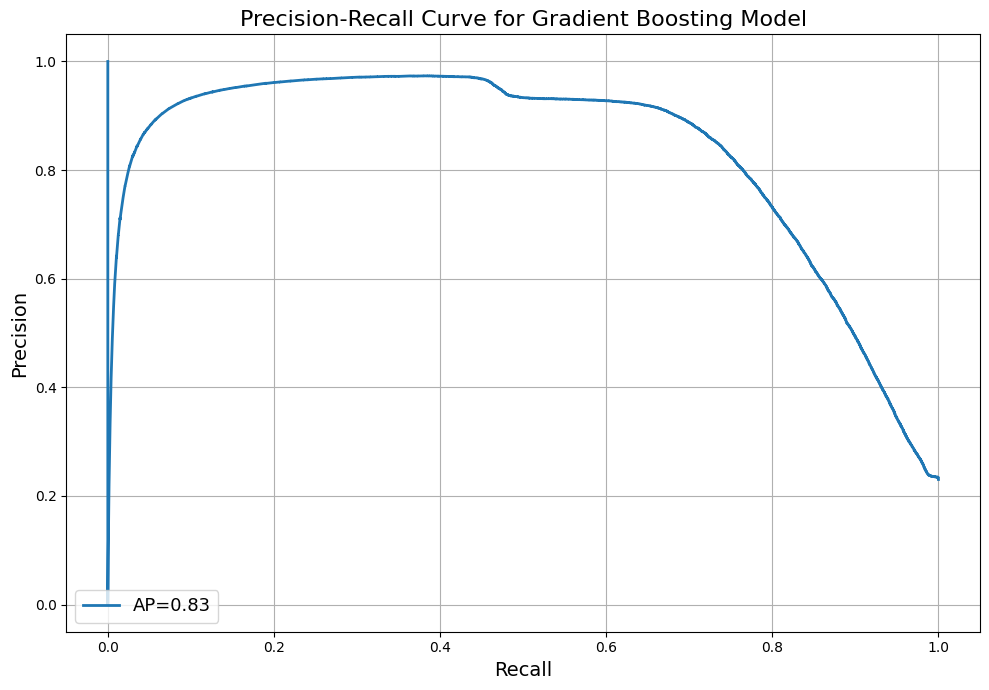

In [98]:
# Compute precision-recall curve values
gnb_precision, gnb_recall, _ = precision_recall_curve(y_test, y_pred_prob_gnb)

# Compute the average precision score
gnb_avg_precision = average_precision_score(y_test, y_pred_prob_gnb)

# Plot the precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(gnb_recall, gnb_precision, label=f'AP={gnb_avg_precision:.2f}', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve for Gradient Boosting Model', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()

# K-Nearest Neighbors

### Finding Optimal K

The optimal number of neighbors is 2


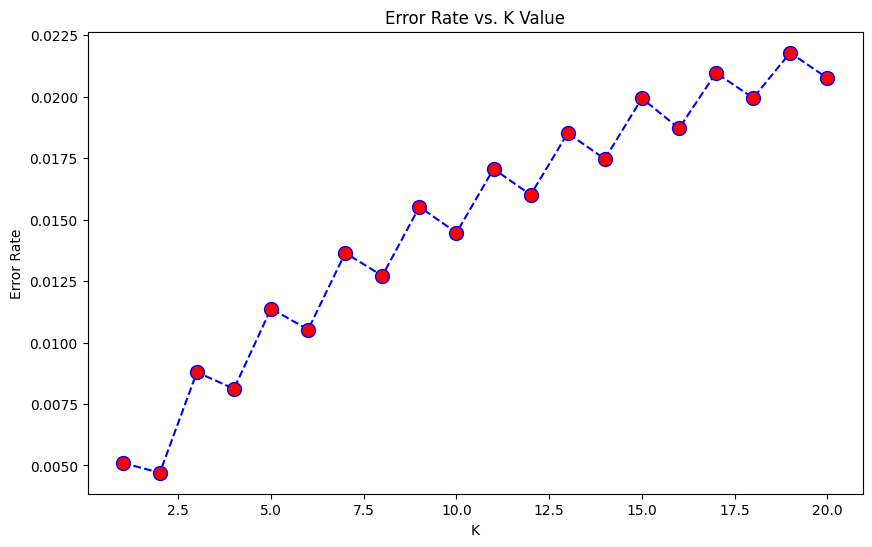

In [105]:
error_rate = []

# Iterate over range of k values
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# Finding the optimal k
optimal_k = error_rate.index(min(error_rate)) + 1  # +1 because the index starts at 0, but k values start at 1
print(f"The optimal number of neighbors is {optimal_k}")

# Plotting the error rate vs k value
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()


Finding Optimal K with Elbow Method adapted from: https://datascienceplus.com/k-nearest-neighbors-knn-with-python/


In [107]:
# Initialize the KNN classifier with the optimal number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=2) # Hardcoding "n_neighbors = 2" since we already found "optimal_k =2"
knn_model.fit(X_train, y_train)

# Evaluate model on training data to check for overfitting
y_train_pred_knn = knn_model.predict(X_train)

print("K-Nearest Neighbors Training Data Performance:")
print(classification_report(y_train, y_train_pred_knn))

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)

# Print classification report
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Training Data Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    442798
           1       1.00      1.00      1.00    132918

    accuracy                           1.00    575716
   macro avg       1.00      1.00      1.00    575716
weighted avg       1.00      1.00      1.00    575716

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    110776
           1       0.98      1.00      0.99     33154

    accuracy                           1.00    143930
   macro avg       0.99      1.00      0.99    143930
weighted avg       1.00      1.00      1.00    143930



This model shows signs of overfitting, comparing between training and test results accross all SMOTE ratios

k-NN Classifier code based on: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# Cross Validating K-Nearest Neighbors

In [55]:
# Cross-validating the K-Nn algorithm at oversampling
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:\n", conf_matrix_knn)

cross_val_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_knn)
print("Mean Cross Validation Score:", cross_val_scores_knn.mean())

# Make predictions using the trained logistic regression model
predicted_class_knn = knn_model.predict(new_data)
print(predicted_class_knn)
# Mapping the predicted class to label fraud or not fraud
predicted_label_knn = 'Fraud' if predicted_class_knn[0] == 1 else 'Not Fraud'
# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_knn)


Cross Validation Scores: [0.99421117 0.9939751  0.99432407 0.9934927  0.99419058]
Mean Cross Validation Score: 0.9940387239745491
[0]
Predicted Label for the New Transaction: Not Fraud


# Visual Evaluations for K-NN

[[110111    665]
 [    12  33142]]


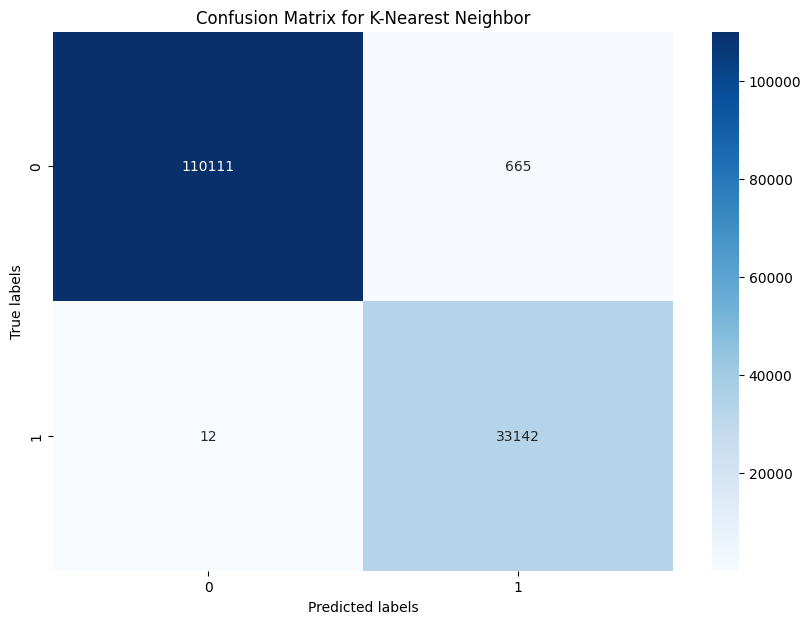

In [108]:
# Confusion matrix plot
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_knn, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-Nearest Neighbor')
plt.show()


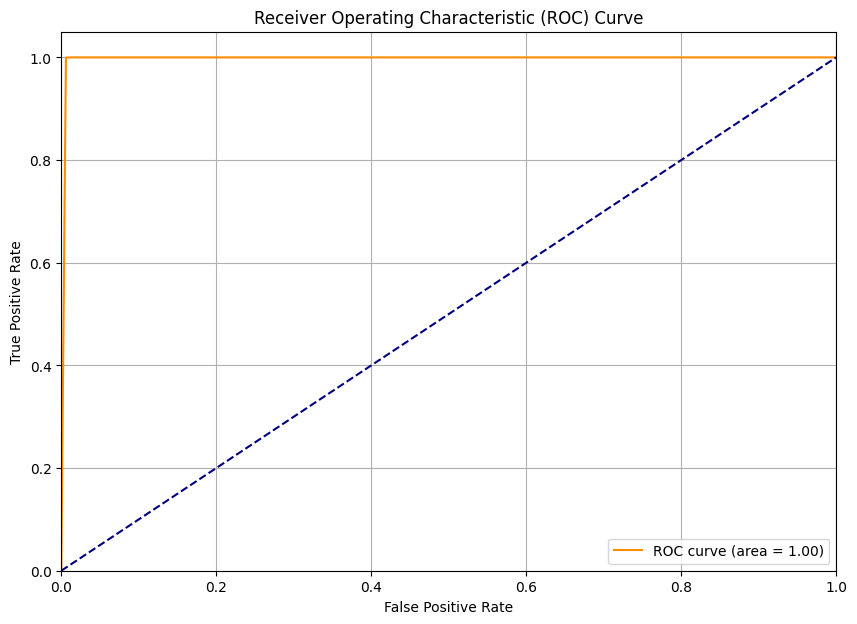

In [124]:
#ROC-AUC Curve for Knn
y_pred_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
knn_fpr, knn_tpr, _ = roc_curve(y_test, y_pred_prob_knn)

# Compute the AUC
knn_roc_auc = auc(knn_fpr, knn_tpr)
plt.figure(figsize=(10, 7))
plt.plot(knn_fpr, knn_tpr, color='darkorange', label='ROC curve (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

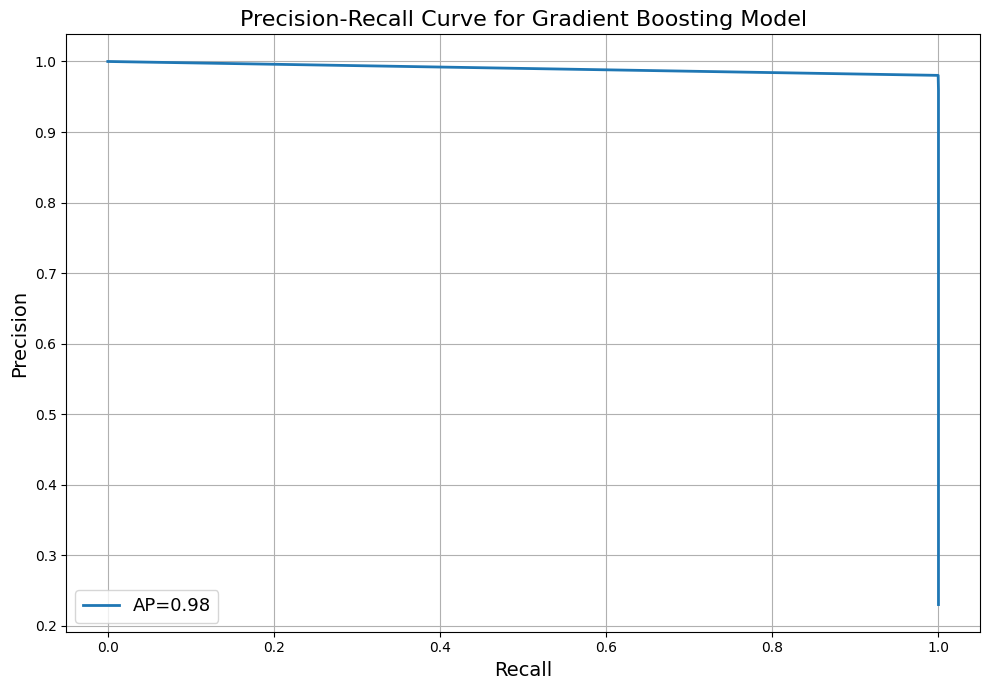

In [120]:
# Compute precision-recall curve values
knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_pred_prob_knn)

# Compute the average precision score
knn_avg_precision = average_precision_score(y_test, y_pred_prob_knn)

# Plot the precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(knn_recall, knn_precision, label=f'AP={knn_avg_precision:.2f}', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve for Gradient Boosting Model', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()